In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.utils import to_categorical
import pickle


import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
directory = './datasets/resampled/'
files = [file for file in os.listdir(directory) if file.endswith('.csv')]

stocks = {}
for file in files:
    df = pd.read_csv(directory + file, index_col='date_time', parse_dates=True)
    df.sort_index(inplace=True)
    df['target'] = np.where(df['mean_px_1'] > 0, 1,
                           np.where(df['mean_px_1'] < 0, -1, 0))
    ticker = df['ticker'][0]
    stocks[ticker] = df
    

In [21]:
df = pd.read_csv('./datasets/russia site/cleaned/gs.csv')
df.head()

,ticker,date,time,price,vol,date_time
0,gs,20190903,93005,201.61,100,2019-09-03 09:30:05
1,gs,20190903,93007,201.61,100,2019-09-03 09:30:07
2,gs,20190903,93012,201.28,100,2019-09-03 09:30:12
3,gs,20190903,93021,201.45,100,2019-09-03 09:30:21
4,gs,20190903,93042,201.04,100,2019-09-03 09:30:42


In [22]:
df['date_time'] = pd.to_datetime(df['date_time'], 
                                     format='%Y-%m-%d %H:%M:%S')
df.set_index('date_time', inplace=True)
df.index = pd.DatetimeIndex(df.index).to_period('ms')
df.sort_index(inplace=True)




In [24]:
intervals = [1, 2, 3, 4, 5, 10, 15, 30, 60]
for i in intervals:
    df[f'px_{i}'] = df['price'].pct_change(i)
df.head()

,ticker,date,time,price,vol,px_1,px_2,px_3,px_4,px_5,px_10,px_15,px_30,px_60
date_time,,,,,,,,,,,,,,
2019-09-03 09:30:05.000,gs,20190903,93005,201.61,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-03 09:30:07.000,gs,20190903,93007,201.61,100,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-03 09:30:12.000,gs,20190903,93012,201.28,100,-0.001637,-0.001637,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-03 09:30:21.000,gs,20190903,93021,201.45,100,0.000845,-0.000794,-0.000794,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-03 09:30:42.000,gs,20190903,93042,201.04,100,-0.002035,-0.001192,-0.002827,-0.002827,NaN,NaN,NaN,NaN,NaN


In [2]:
df = pd.read_csv('./datasets/resampled/gs.csv', index_col='date_time', parse_dates=True, nrows=100_000)
df.sort_index(inplace=True)
df.head()

,vol,price open,price high,price low,price close,mean_price,high_px_1,mean_px_1,high_px_2,mean_px_2,...,mean_px_5,high_px_10,mean_px_10,high_px_15,mean_px_15,high_px_30,mean_px_30,high_px_60,mean_px_60,ticker
date_time,,,,,,,,,,,,,,,,,,,,,
2019-09-03 09:30:05,100,201.61,201.61,201.61,201.61,201.61,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gs
2019-09-03 09:30:06,0,201.61,201.61,201.61,201.61,201.61,0.0,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gs
2019-09-03 09:30:07,100,201.61,201.61,201.61,201.61,201.61,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gs
2019-09-03 09:30:08,0,201.61,201.61,201.61,201.61,201.61,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gs
2019-09-03 09:30:09,0,201.61,201.61,201.61,201.61,201.61,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gs


In [25]:
df['target'] = np.where(df['px_1'] > 0, 2,
                           np.where(df['px_1'] < 0, 0, 1))
df.dropna(inplace=True)
df['target'].value_counts(normalize=True)

2    0.37790
0    0.37383
1    0.24827
Name: target, dtype: float64

In [13]:
(df['mean_px_1']==0).sum()

98580

In [26]:
X = df.drop(columns=['target', 'ticker', 'date', 'time'])
y = df['target']
y = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [27]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

tsg_len = 5
tsg_batch = 512
train_seq = TimeseriesGenerator(X_train_sc, y_train, 
                                length=tsg_len, batch_size=tsg_batch)
test_seq = TimeseriesGenerator(X_test_sc, y_test, 
                               length=tsg_len, batch_size=tsg_batch)


In [28]:
# Design RNN
model = Sequential()
model.add(GRU(32,
             input_dim=X.shape[1],
             return_sequences=True)) # True if next layer is RNN
model.add(GRU(16,return_sequences=False)) # False if next layer is Dense
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
# output layer
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(),
              metrics = ['accuracy'])
hist = model.fit(train_seq,
                epochs=10,
                validation_data=test_seq)


Epoch 1/10
160/160 [==============================] - 2s 12ms/step - loss: 1.0827 - accuracy: 0.3802 - val_loss: 1.0800 - val_accuracy: 0.3855
Epoch 2/10
160/160 [==============================] - 1s 9ms/step - loss: 1.0781 - accuracy: 0.3886 - val_loss: 1.0787 - val_accuracy: 0.3896
Epoch 3/10
160/160 [==============================] - 1s 9ms/step - loss: 1.0767 - accuracy: 0.3929 - val_loss: 1.0795 - val_accuracy: 0.3908
Epoch 4/10
160/160 [==============================] - 1s 9ms/step - loss: 1.0756 - accuracy: 0.3970 - val_loss: 1.0780 - val_accuracy: 0.3956
Epoch 5/10
160/160 [==============================] - 1s 9ms/step - loss: 1.0748 - accuracy: 0.3991 - val_loss: 1.0783 - val_accuracy: 0.3941
Epoch 6/10
160/160 [==============================] - 1s 9ms/step - loss: 1.0742 - accuracy: 0.4001 - val_loss: 1.0756 - val_accuracy: 0.4015
Epoch 7/10
160/160 [==============================] - 1s 9ms/step - loss: 1.0734 - accuracy: 0.4026 - val_loss: 1.0772 - val_accuracy: 0.3958
Epoch

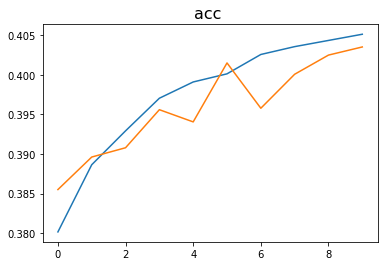

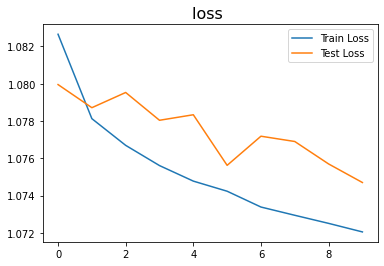

In [33]:
plt.plot(hist.history['accuracy'], label = 'Train Accuracy')
plt.plot(hist.history['val_accuracy'], label = 'Test Accuracy')

plt.title(label = f'acc ', fontsize=16)
plt.show()
# plt.savefig(f'./charts/rnn/acc/{company}.png', bbox_inches='tight')
# plt.savefig(f'./charts/rnn/acc/{company}t.png', transparent=True)


plt.plot(hist.history['loss'], label = 'Train Loss')
plt.plot(hist.history['val_loss'], label = 'Test Loss')
plt.title(label = f'loss ', fontsize=16)
plt.legend()
plt.show()
# plt.savefig(f'./charts/rnn/loss/{company}.png', bbox_inches='tight')
# plt.savefig(f'./charts/rnn/loss/{company}t.png', transparent=True)

In [30]:
preds = model.predict_classes(test_seq)

preds.sort()

preds

array([0, 0, 0, ..., 2, 2, 2])

In [36]:
preds.sum()

338

In [37]:
len(preds)

2576233

In [31]:
unique_elements, counts_elements = np.unique(preds, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[    0     1     2]
 [11074  1056 15143]]


In [12]:
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[0.000000e+00 1.000000e+00]
 [5.152496e+06 2.576248e+06]]


In [13]:
unique_elements, counts_elements = np.unique(y, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[0.0000000e+00 1.0000000e+00]
 [2.0609978e+07 1.0304989e+07]]


In [ ]:
with open(f'./models/rnn/{company}rnn_notweets.pkl', 'wb') as pickle_out:
    pickle.dump(model, pickle_out)

In [32]:
df['target'].value_counts()

2    41233
0    40789
1    27089
Name: target, dtype: int64

In [17]:
y

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)